**2nd strategy for E.coli 5-HTP production**

In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

In [2]:
model = read_sbml_model('data/iML1515.xml')

**BH4 synthesis pathway**

GTP cyclohydrolase I\
GTP + water <-> dihydromonapterin-triphosphate + formate + H+

In [5]:
#design reaction
gchi = Reaction('gchi')
gchi.add_metabolites({model.metabolites.gtp_c: -1,
                      model.metabolites.h2o_c: -1,
                      model.metabolites.dhmptp_c: 1,
                      model.metabolites.for_c: 1,
                      model.metabolites.h_c: 1
                     })
print(gchi.build_reaction_string())

gtp_c + h2o_c --> dhmptp_c + for_c + h_c


In [6]:
#add reaction to the system
model.add_reactions([gchi])
model.reactions.gchi

Reaction identifier,gchi
Name,
Memory address,0x07ff765f55400
Stoichiometry,gtp_c + h2o_c --> dhmptp_c + for_c + h_c GTP C10H12N5O14P3 + H2O H2O --> Dihydromonapterin-triphosphate + Formate + H+
GPR,
Lower bound,0.0
Upper bound,1000.0


6-pyruvate-tetrahydropterin synthase\
dihydromonapterin-triphosphate <-> triphosphate + 6-pyruvoyltetrahydropterin

In [9]:
#add metabolites
six_pyruvoyltetrahydropterin = Metabolite(id='pthp_c', compartment='c')

In [10]:
#design reaction
ptsp = Reaction('ptsp')
ptsp.add_metabolites({model.metabolites.dhmptp_c: -1,
                      model.metabolites.pppi_c: 1,
                      six_pyruvoyltetrahydropterin: 1,
                     })
print(ptsp.build_reaction_string())

dhmptp_c --> pppi_c + pthp_c


In [11]:
#add reaction to the system
model.add_reactions([ptsp])
model.reactions.ptsp

Reaction identifier,ptsp
Name,
Memory address,0x07ff765f7f250
Stoichiometry,dhmptp_c --> pppi_c + pthp_c Dihydromonapterin-triphosphate --> Inorganic triphosphate +
GPR,
Lower bound,0.0
Upper bound,1000.0


sepiapterin reductase\
2 H+ + 2 NADPH + 6-pyruvoyltetrahydropterin <-> 2 NADP+ + tetrahydrobiopterin (BH4)

In [12]:
# add metabolites
tetrahydrobiopterin = Metabolite(id='thbpt_c', compartment='c')

In [13]:
#design reaction
spr = Reaction('spr')
spr.add_metabolites({model.metabolites.h_c: -2,
                      model.metabolites.nadph_c: -2,
                      six_pyruvoyltetrahydropterin: -1,
                      model.metabolites.nadp_c: 2,
                      tetrahydrobiopterin: 1
                     })
print(spr.build_reaction_string())

2 h_c + 2 nadph_c + pthp_c --> 2 nadp_c + thbpt_c


In [14]:
#add reaction to the system
model.add_reactions([spr])
model.reactions.spr

Reaction identifier,spr
Name,
Memory address,0x07ff765f55580
Stoichiometry,2 h_c + 2 nadph_c + pthp_c --> 2 nadp_c + thbpt_c 2 H+ + 2 Nicotinamide adenine dinucleotide phosphate - reduced + --> 2 Nicotinamide adenine dinucleotide phosphate +
GPR,
Lower bound,0.0
Upper bound,1000.0


**BH4 regeneration pathway**

pterin-4alpha-carbinolamine dehydratase (PCD)\
4a-hydroxytetrahydrobiopterin (hydro-BH4) <-> dihydrobiopterin (BH2) + water 

In [18]:
#add metabolites
dihydrobiopterin = Metabolite(id='dhbpt_c', compartment='c')
four_alpha_hydroxytetrahydrobiopterin = Metabolite(id='hthbpt_c', compartment='c')

In [19]:
#design reaction
pcd = Reaction('pcd')
pcd.add_metabolites({four_alpha_hydroxytetrahydrobiopterin: -1,
                      dihydrobiopterin: 1,
                      model.metabolites.h2o_c: 1
                     })
print(pcd.build_reaction_string())

hthbpt_c --> dhbpt_c + h2o_c


In [20]:
#add reaction to the system
model.add_reactions([pcd])
model.reactions.pcd

Reaction identifier,pcd
Name,
Memory address,0x07ff765f55040
Stoichiometry,hthbpt_c --> dhbpt_c + h2o_c --> + H2O H2O
GPR,
Lower bound,0.0
Upper bound,1000.0


dihydropteridine reductase (DHPR)\
dihydrobiopterin (BH2) + H+ + NADPH <-> NADP+ + tetrahydrobiopterin (BH4)

In [21]:
#design reaction
dhpr = Reaction('dhpr')
dhpr.add_metabolites({model.metabolites.dhbpt_c: -1,
                      model.metabolites.h_c: -1,
                      model.metabolites.nadph_c: -1,
                      model.metabolites.nadp_c: 1,
                      model.metabolites.thbpt_c: 1
                     })
print(dhpr.build_reaction_string())

dhbpt_c + h_c + nadph_c --> nadp_c + thbpt_c


In [22]:
#add reaction to the system
model.add_reactions([dhpr])
model.reactions.dhpr

Reaction identifier,dhpr
Name,
Memory address,0x07ff765fc1d60
Stoichiometry,dhbpt_c + h_c + nadph_c --> nadp_c + thbpt_c + H+ + Nicotinamide adenine dinucleotide phosphate - reduced --> Nicotinamide adenine dinucleotide phosphate +
GPR,
Lower bound,0.0
Upper bound,1000.0


**5-HTP synthesis pathway**

tryptophan hydroxylase generates 5-hydroxytryptophan\
oxygen + tryptophan (trp) + tetrahydrobiopterin (BH4) <-> 5-hydroxytryptophan (5-HTP) +  4a-hydroxytetrahydrobiopterin (hydro-BH4)

In [23]:
#add metabolites to the system
hydroxytryptophan = Metabolite(id='htrp_c', compartment='c')

In [24]:
#design reaction
tph = Reaction('tph')
tph.add_metabolites({tetrahydrobiopterin: -1,
                      model.metabolites.o2_c: -1,
                      model.metabolites.trp__L_c: -1,
                      four_alpha_hydroxytetrahydrobiopterin: 1,
                      hydroxytryptophan: 1
                     })
print(tph.build_reaction_string())

o2_c + thbpt_c + trp__L_c --> hthbpt_c + htrp_c


In [25]:
#add reaction to the system
model.add_reactions([tph])
model.reactions.tph

Reaction identifier,tph
Name,
Memory address,0x07ff765f6a910
Stoichiometry,o2_c + thbpt_c + trp__L_c --> hthbpt_c + htrp_c O2 O2 + + L-Tryptophan --> +
GPR,
Lower bound,0.0
Upper bound,1000.0


**Remove 5-HTP from the system**

In [27]:
five_hydroxytryptophan_exchange = Reaction('EX_htrp')
five_hydroxytryptophan_exchange.add_metabolites({model.metabolites.htrp_c: -1})
model.add_reaction(five_hydroxytryptophan_exchange)

**Optimize model**

In [28]:
print(model.objective)

Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685


In [29]:
model.optimize().objective_value

0.8769972144269668

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [30]:
with model:
    print(model.reactions.tph)
    model.objective = model.reactions.tph
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print(max_5HTP_production)
    print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

tph: o2_c + thbpt_c + trp__L_c --> hthbpt_c + htrp_c
4.279204339963834
0.0


**Observing how the growth rate changes with increasing 5-HTP export flux**

In [50]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [32]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.tph],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [33]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,tph
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


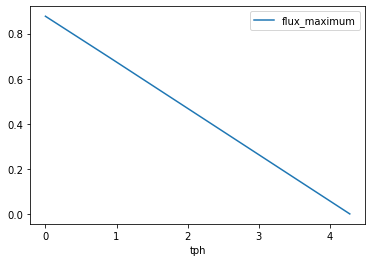

In [35]:
ppp_5HTP.plot(x='tph', y='flux_maximum')

**Optmizing 5-HTP production and growth rate**

In [36]:
from cobra.flux_analysis import flux_variability_analysis

In [37]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.tph, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

     minimum   maximum
tph      0.0  2.144746


Keeping growth rate at 50%, we get around 50% of maximum 5-HTP flux, which is bigger than in case of B.subtilis, but smaller than 1st strategy for E.coli

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [39]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.tph
        solution = model.optimize()
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print ('5-HTP export flux:', solution.fluxes.tph, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

No solutions displayed, no single knock-outs and optmization to maximum 5-HTP production yields positive growth rate

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [40]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.tph > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.tph, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In [42]:
print(knock_out_list)

Empty DataFrame
Columns: [Gene ID, 5-HTP export flux, Biomass production flux]
Index: []


No solutions, no single knock-outs give rise to positive htp flux with maximum growth rate

**Check whether change of carbon source will influence the growth rate at maximum 5-HTP flux**

In [45]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [48]:
medium = model.medium

with model:
    #replace glucose with each exchange reaction from the possible carbon source reactions
    for reaction in carbon_uptake:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.tph
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


No solutions, changing of medium does not influence the increase of growth rate at 5-HTP maximum flux production